[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/axr/blob/master/axr/01_bandits.ipynb)

# Exploración vs Explotación

La principal diferencia entre el axr y el resto de métodos de aprendizaje es que durante el entrenamiento un agente aprende a través de la *evaluación* de las acciones tomadas en vez de ser *instruido* diciéndole exactamente qué acciones son las correctas (aprendizaje supervisado). Es por este motivo que necesitamos de una exploración activa, de forma que a través de la prueba y el error nuestro agente descubra las mejores acciones para poder explotarlas en el futuro.


## *Whac-A-Mole*

En este post vamos a estudiar el aspecto evaluador en su configuración más básica, sin considerar aprendizaje para actuar en más de una situación. Esto nos permitirá introducir los conceptos básicos de exploración vs explotación que usaremos y extendermos más adelante para resolver problemas más complejos. Para ello usaremos de ejemplo el juego [*Whac-A-Mole*](https://es.wikipedia.org/wiki/Whac-A-Mole). En la versión original arcade de este juego, el jugador tenía que golpear con un mazo a topos pequeños que iban apareciendo de manera aleatoria. Cuánto más rápido golpease, más puntos obtenía. Nosotros usaremos una versión un poco modificada, en la que el jugador tendrá que clicar los topos en vez de golpearlos (los cuales estarán siempre en pantalla en vez de ir apareciendo y desapareciendo). Además, cada uno de los topos dará una cantidad de puntos diferentes, un valor numérico obtenido de en una distribución de probabilidad estacionaria. Así pues, el problema se base en tomar una decisión (acción) de entre varias: ¿qué topo golpear para obtener la máxima puntuación?

![](https://media1.giphy.com/media/ebITvSXYKNvRm/giphy.gif)

Empezamos definiendo el *valor* de una acción como la **recompensa esperada** tras seleccionar dicha acción.

$$
    q_*(a) = \mathbb{E}[R_t | A_t = a]
$$

donde $q_*(a)$ es el valor de la acción $a$, que corresponde a la acción $A_t$ tomada en el instante $t$ y $R_t$ es su recompensa. Conociendo este valor, el problema se resuelve escogiendo en cada momento aquella acción con mayor valor. El problema es que, a priori, no conocemos este valor, pero podemos aproximarlo. Para ello, definimos $Q_t(a)$ como el valor estimado de la acción $a$ en el instante $t$, cuyo valor queremos que sea tan cercano a $q_*(a)$ como sea posible.

Si en cada instante $t$ llevamos a cabo la acción con un mayor valor estimado, estremos **explotando** nuestro conocimiento y es el método adecuado si queremos maximizar la recompensa final. Si elegimos otras acciones con un menor valor estimado, estermos **explorando** con el objetivo de encontrar nuevos estados desconocidos con mayor recompensa. El correcto balance de ambas estrategias es crucial para encontrar soluciones óptimas, pero cualquier método necesita de algún tipo de conocimiento previo sobre el entorno y su comportamiento. Generalmente se prefiere una mayor exploración al principio, cuando el conocimiento del entorno es limitado, que va disminuyendo en favor de una mayor explotación a medida que este conocimiento mejora.

## Métodos de acción-valor

Los métodos de **acción-valor** consisten en la estimación de los valores de acciones para poder usarlos a la hora de tomar decisiones. Una manera simple de estimar el valor de una acción consiste en promediar la recompensa recibida en un conjunto de episodios.


$$
    Q_t(a) = \frac{\sum_{i=1}^{t-1} R_i \cdot \mathbb{1}_{A_i=a}}{\sum_{i=1}^{t-1}\mathbb{1}_{A_i=a}}
$$

donde $\mathbb{1}_{x}$ es $1$ si $x$ es verdad y $0$ en caso contrario. En el caso que el denominador sea 0, $Q_t(a)$ se iguala a un valor por defecto (por ejemplo 0) mientras que si el denominador crece hacia infinito, $Q_t(a)$ converge a $q_*(a)$. La forma más simple de escoger una acción será elegir aquella con el valor estimado más grande.


$$
    A_t = \underset{a}{\arg\max} \, Q_t(a)
$$

Una alternativa para favorecer la exploración consiste en tomar acciones aleatorias de vez en cuando, con una probabilidad $\epsilon$. Este tipo de métodos se conocen como $\epsilon-greedy$. En el límite, todas las acciones serán esogidas asegurando que $Q_t(a)$ converge a $q_*(a)$. Vamos a comparar ambos métodos en el caso de tener 5 topos en nuestro juego. Para cada topo, el valor óptimo $q_*(a)$ y su recompensa será un valor aleatorio elegido de una distribución normal con media $q_*(a)$ y desviación estándar 1.

In [226]:
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(42)

mu, sigma = 0, 1
q = {k+1: v for k, v in enumerate(np.random.normal(mu, sigma, 5))}
q

{1: 0.4967141530112327,
 2: -0.13826430117118466,
 3: 0.6476885381006925,
 4: 1.5230298564080254,
 5: -0.23415337472333597}

Ahora generaremos un número elevado de partidas y calcularemos la recompensa media obtenida a lo largo del entrenamiento para diferentes valores de $\epsilon$.

In [227]:
partidas = 1000
turnos = 100
epsilons = [0, 0.25, 0.5, 0.75, 0.1]
recompensas_medias = np.zeros((len(epsilons), turnos))
acciones_optimas = np.zeros((len(epsilons), turnos))

for ej in range(partidas):
    mejor_accion = max(q, key=q.get)
    for i, e in enumerate(epsilons):
        Q = {k: 0 for k in range(1,6)}
        acciones = {k: 0 for k in range(1,6)}
        recompensas = {k: 0 for k in range(1,6)}


        for exp in range(turnos):

            # elegir acción
            # generamos un numero aleatorio, si el numero aleatorio es menor que epsilon(e) el agente explora

            if np.random.uniform(0,1) < e:

                # acción aleatoria
                # genera un número entre 0 y 4, + 1, obtenemos un número entre 1 y 5, que representa una acción.
                a = np.random.randint(5) + 1

            # se ejecuta si el agente decide explotar
            else:

                # Elegir segunda mejor acción

                # Ordena las acciones representadas en el diccionario de acuerdo al valor de Q.get en orden decendente
                # El diccionario Q contiene los valores estimados de recompensa para cada acción.
                # La lista sorted_actions contiene las acciones ordenadas de mayor a menor en términos de recompensa esperada.
                sorted_actions = sorted(Q, key=Q.get, reverse=True)

                #  Después de ordenar las acciones, sorted_actions[1] selecciona la segunda mejor acción en lugar de la mejor sorted_actions[0].
                # Este cambio se realiza para analizar el rendimiento de elegir la segunda mejor acción en lugar de la mejor.
                a = sorted_actions[1]  # Segunda mejor acción

            acciones[a] += 1
            recompensa = q[a]
            recompensas[a] += recompensa
            Q[a] = recompensas[a]/acciones[a]
            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)

recompensas_medias /= partidas
acciones_optimas /= partidas

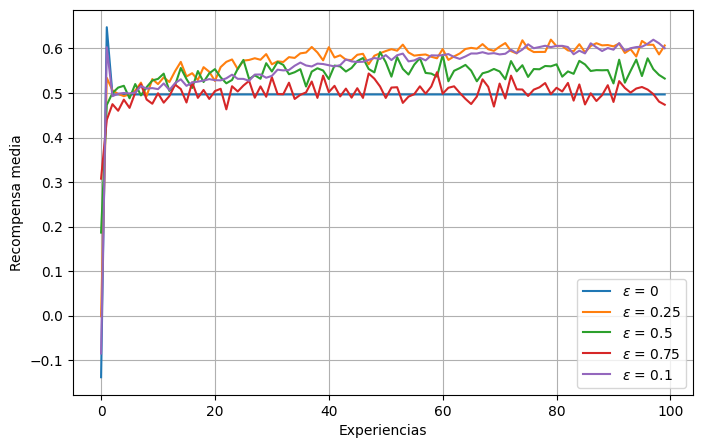

In [228]:
plt.figure(figsize=(8,5))
for i, e in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')# episodios
plt.ylabel('Recompensa media')
plt.show()

A medida que aumenta el valor del epsilon el modelo tiende a explorar mas lo que reduce la recompensa  si tomamos un 0.25 equilibramos la explotacion y exploracion, lo que puede resultar una convervengia relativamente rapida hacia recompensas promedio mas altas

Como podemos ver un método *greedy* se queda encallado con la primera acción buena que encuentra (la cual puede, o no, ser la mejor), mientras que si le dejamos explorar es posible que encuentre nuevas acciones que den como resultado mayores recompensas a largo plazo.

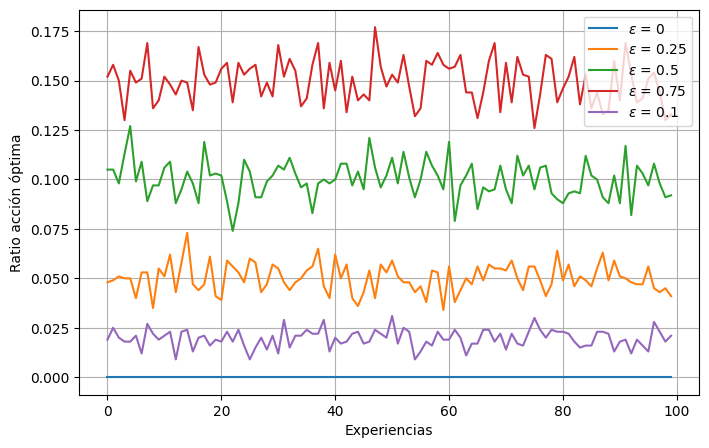

In [229]:
plt.figure(figsize=(8,5))
for i, e in enumerate(epsilons):
    plt.plot(acciones_optimas[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.show()

Al incrementar el episilon, el modelo explora más y, por tanto, elige la segunda mejor opción con mayor frecuencia en lugar de la óptima, lo cual reduce la tasa de selección de la mejor acción.

Un valor bajo de $\epsilon$ converge más lento, y en este caso no tiene suficiente tiempo para descubrir la mejor acción. Como hemos comentado brevemente antes, una técnica muy usada consiste en ir reduciendo el valor de $\epsilon$ durante el entrenamiento, así podemos explorar un gran espacio de acciones al principio y enfocarnos en explotar acciones buenas al final. La eficacia de usar un valor de $\epsilon$ u otro dependerás del caso, es un hiperparámetro más a optimizar. En casos con una variancia en las recompensas elevada necesitaremos más exploración, por lo que podemos esperar todavía mejor resultado que sin exploración. Por otro lado, si la variancia fuese 0, un método *greedy* podría encontraría el valor óptimo solo con probar cada acción una vez. Aún así, usar $\epsilon > 0$ suele dar mejor resultado en la mayoría de casos.

## Implementación incremental

Vamos a ver ahora cómo calcular los valores promedios necesarios para estimar los valores de las acciones de manera más eficiente. En la implementación anterior hemos ido guardando la recompensa obtenida al realizar cada acción, así como el número de veces que una acción se lleva a cabo para calcular el valor de la acción. Sin embargo podemos obtener el mismo resultado con un método incremental.

$$
    Q_{n+1} = Q_n + \alpha [R_n - Q_n]
$$

donde $\alpha \in (0, 1)$ es una contante. Esta fórmula se repite a menudo en el axr, y generalmente la veremos en la siguiente forma

$$
    \text{nuevo valor} \leftarrow \text{viejo valor} + \text{ratio de cambio} \, [\text{valor objetivo}-\text{viejo valor}]
$$

In [230]:
partidas = 1000
turnos = 100
alpha = 0.5
epsilons = [0., 0.01, 0.1]
recompensas_medias = np.zeros((len(epsilons), turnos))
acciones_optimas = np.zeros((len(epsilons), turnos))

for ej in range(partidas):
    mejor_accion = max(q, key=q.get)
    for i, e in enumerate(epsilons):
        Q = {k: 0 for k in range(1,6)}
        for exp in range(turnos):
            # elegir acción
            if np.random.uniform(0,1) < e:
                # acción aleatoria
                a = np.random.randint(5) + 1
            else:
                # acción con mayor valor
                maxQ = -100
                for j in range(1, 6):
                    if Q[j] > maxQ:
                        maxQ = Q[j]
                        a = j
            recompensa = q[a]
            Q[a] += alpha*(recompensa - Q[a])
            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)

recompensas_medias /= partidas
acciones_optimas /= partidas

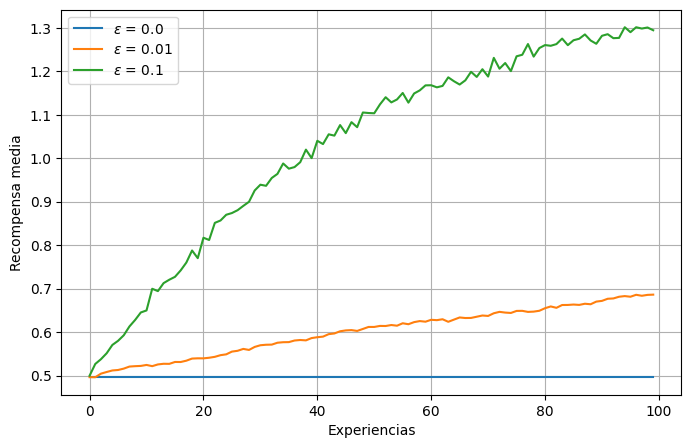

In [231]:
plt.figure(figsize=(8,5))
for i, e in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.show()

## Valores iniciales optimistas

Los métodos vistos hasta ahora dependían de las estimaciones iniciales $Q_1(a)$. Esto nos introduce un *bias* que implica que en la práctica la inicialización se convierte en un hiperparámetro más que el ususario debe escoger. Podemos usar este hecho en nuestra ventaja. Si inicializamos los valores de las acciones por encima de sus valores reales, nuestro agente intentrá llevar a cabo estas acciones, y enseguida las descartará ya que la recompensa obtenida será menor y por lo tanto su valor disminuirá. Esto significa que includo un agente *greedy* probará todas las acciones antes de quedarse con una, habiendo explorado un poco.

In [232]:
partidas = 1000
turnos = 100
alpha=0.5
epsilons = [0, 0.1]
recompensas_medias = np.zeros((len(epsilons), turnos))
acciones_optimas = np.zeros((len(epsilons), turnos))

for ej in range(partidas):
    mejor_accion = max(q, key=q.get)
    for i, e in enumerate(epsilons):
        Q = {k: 0 for k in range(1,6)}
        # inicializamos a valores altos si el agente es greedy
        if e == 0:
            Q = {k: 5 for k in range(1,6)}
        for exp in range(turnos):
            # elegir acción
            if np.random.uniform(0,1) < e:
                # acción aleatoria
                a = np.random.randint(5) + 1
            else:
                # acción con mayor valor
                maxQ = -100
                for j in range(1, 6):
                    if Q[j] > maxQ:
                        maxQ = Q[j]
                        a = j
            recompensa = q[a]
            Q[a] += alpha*(recompensa - Q[a])
            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)

recompensas_medias /= partidas
acciones_optimas /= partidas

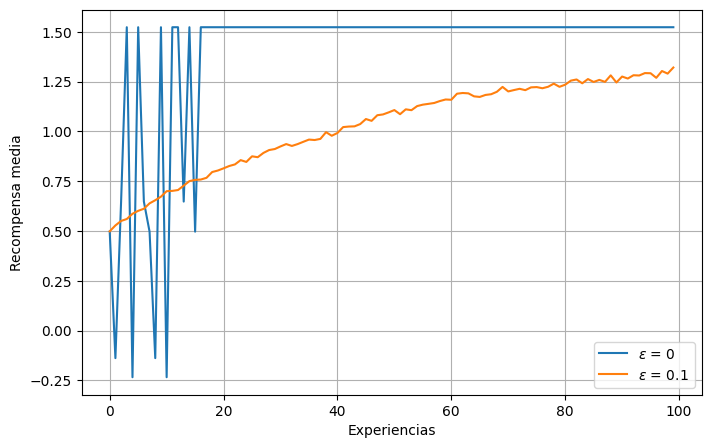

In [233]:
plt.figure(figsize=(8,5))
for i, e in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.show()

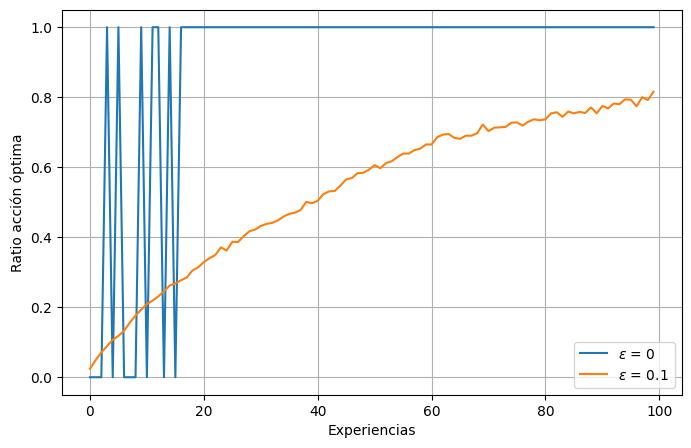

In [234]:
plt.figure(figsize=(8,5))
for i, e in enumerate(epsilons):
    plt.plot(acciones_optimas[i], label=f'$\epsilon$ = {e}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.show()

Ahora, nuestro agente *greedy* explora todas las acciones antes de elegir la mejor, la cual explota hasta el final. Esta técnica funciona bien en problemas estacionarios, pero si el problema no es estacionario y las recompensas van cambiando durante el tiempo tendremos el mismo problema que antes con un agente que no explora.

## Selección de acciones con intervalo de confianza

El método $\epsilon-greedy$ basa la exploración en escoger acciones aleatorias sin ningun tipo de preferencia, pero una mejor forma de hacerlo es escogiendo aquellas acciones menos exploradas con mayor potencial.

$$
    A_t = \underset{a}{\arg\max} \, \left[ Q_t(a) + c \sqrt{\frac{\text{ln} \, t}{N_t(a)}} \right]
$$

donde $\text{ln} \, t$ es el logaritmo natural de $t$, $N_t(a)$ es el número de veces que se has efectuado la acción $a$ y $c > 0$ es una constante que controla el ratio de exploración.

In [235]:
import math

partidas = 1000
turnos = 100
alpha=0.5
c = 1
epsilons = [0.1, 0.1]
recompensas_medias = np.zeros((len(epsilons), turnos))
acciones_optimas = np.zeros((len(epsilons), turnos))

for ej in range(partidas):
    mejor_accion = max(q, key=q.get)
    for i, e in enumerate(epsilons):
        Q = {k: 0 for k in range(1,6)}
        acciones = {k: 1 for k in range(1,6)}
        for exp in range(turnos):
            if i == 0: # UCB
                maxQ = -100
                for j in range(1, 6):
                    A = Q[j] + c*math.sqrt(math.log(exp+1)/(acciones[j]))
                    if A > maxQ:
                        maxQ = A
                        a = j
            else:
                # elegir acción
                if np.random.uniform(0,1) < e:
                    # acción aleatoria
                    a = np.random.randint(5) + 1
                else:
                    # acción con mayor valor
                    maxQ = -100
                    for j in range(1, 6):
                        if Q[j] > maxQ:
                            maxQ = Q[j]
                            a = j
            acciones[a] += 1
            recompensa = q[a]
            Q[a] += alpha*(recompensa - Q[a])
            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)

recompensas_medias /= partidas
acciones_optimas /= partidas

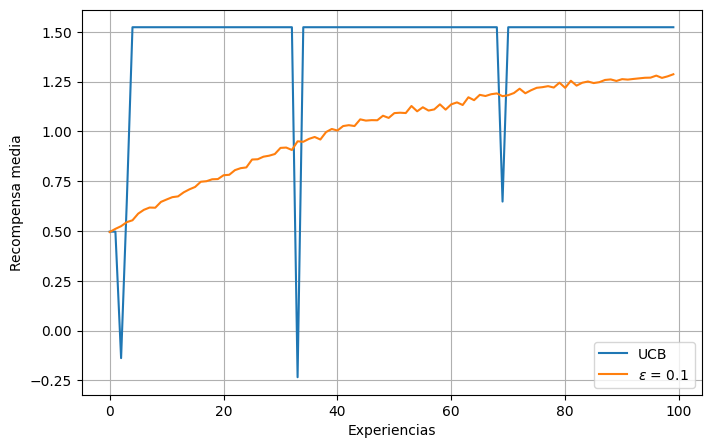

In [236]:
plt.figure(figsize=(8,5))
for i, e in enumerate(epsilons):
    plt.plot(recompensas_medias[i], label=f'$\epsilon$ = {e}' if i != 0 else "UCB")
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.show()

Si bien esta técnica funciona mejor para este problema, su uso no está muy generalizado ya que no es fácil de integrar en problemas de axr con grandes espacios de búsqueda o preblemas no estacionarios.

## Algoritmos de Gradiente

Hasta el momento sólo hemos considerado métodos que estiman el valor de las acciones y utilizan estas estimaciones para seleccionar la acción que ejecutar en cada momento. Sin embargo, existen otras alternativas, como asignar una *preferencia* a cada acción $H_t(a)$. Cuanta mayor sea la preferencia de una acción, más veces será ejecutada. Podemos definir $\pi_t(a)$ como la probabilidad de escoger la acción $a$ en el instante $t$

$$
    \pi_t(a) = \frac{e^{H_t(a)}}{\sum_{b=1}^k e^{H_t(b)}}
$$

Existe un algoritmo para entrenar un agente bajo estas condiciones basado en la idea de ascenso por gradiente.

$$
    \begin{array}{ll}
        H_{t+1}(a) = H_{t}(a) + \alpha(R_t-\tilde{R_t})(1-\pi_t(A_t)) & \text{y} \\
        H_{t+1}(a) = H_{t}(a) - \alpha(R_t-\tilde{R_t})\pi_t(a) & \text{para toda } a \neq A_t
    \end{array}
$$

donde $\tilde{R_t}$ es el promedio de todas las recompensas hasta el instante $t$ (incluído). Este valor actúa como referencia con la que comparamos la recompensa. Si es mayor, la probabilidad de escoger esa acción en el futuro aumenta. Si es menor, la probabilidad se reduce. Las acciones no escogidas, se actualizan en el sentido opuesto.


In [237]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

In [223]:
partidas = 1000
turnos = 100
alphas = [0.1, 0.4]
recompensas_medias = np.zeros((len(epsilons), turnos))
acciones_optimas = np.zeros((len(epsilons), turnos))
for ej in range(partidas):
    mejor_accion = max(q, key=q.get)
    for i, alpha in enumerate(alphas):
        H = np.zeros(5)
        pi = softmax(H)
        recompensas = []
        for exp in range(turnos):
            # elegir acción
            a = np.random.choice(range(1,6),1,p=pi)[0]
            recompensa = q[a]
            recompensas.append(recompensa)
            recompensa_media = np.mean(recompensas)
            # actualizar preferencias
            for j in range(5):
                if j == a-1:
                    H[j] += alpha*(recompensa - recompensa_media)*(1-pi[j])
                else:
                    H[j] -= alpha*(recompensa - recompensa_media)*pi[j]
            # actualizar probabilidades
            pi = softmax(H)
            recompensas_medias[i][exp] += recompensa
            acciones_optimas[i][exp] += (a == mejor_accion)

recompensas_medias /= partidas
acciones_optimas /= partidas

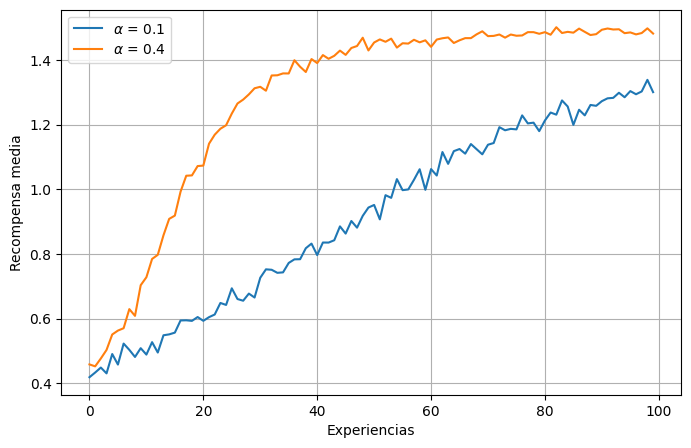

In [224]:
plt.figure(figsize=(8,5))
for i, a in enumerate(alphas):
    plt.plot(recompensas_medias[i], label=fr'$\alpha$ = {a}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Recompensa media')
plt.show()

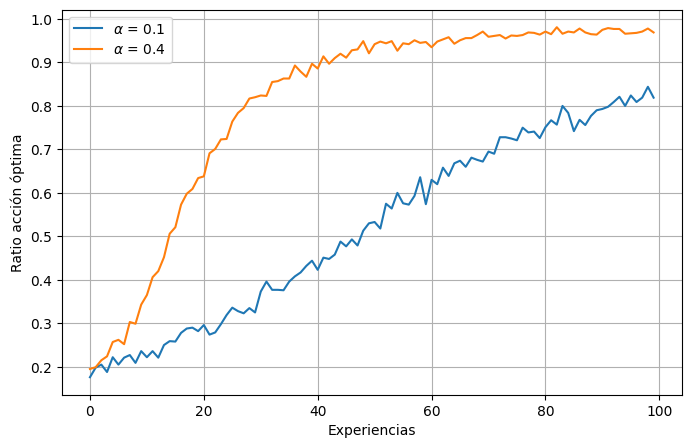

In [225]:
plt.figure(figsize=(8,5))
for i, a in enumerate(alphas):
    plt.plot(acciones_optimas[i], label=fr'$\alpha$ = {a}')
plt.legend()
plt.grid(True)
plt.xlabel('Experiencias')
plt.ylabel('Ratio acción óptima')
plt.show()

## Búsqueda asociativa

En el ejemplo ilustrado en este post hemos tratado con una tarea no asociativa. En este tipo de tareas no es necesario asociar diferentes acciones a diferentes situaciones. Sin embargo, en una tarea de axr general existen multitud de situaciones en las que podemos llevar a cabo la misma acción, con diferente resultado en cada caso, y el objetivo es será el de aprender una *política*: una relación entre situaciones y las mejores acciones que llevar a cabo en esa situación. Aún así, seguiremos necesitado de prueba y error para encontrar las mejores acciones y poder asociarlas a las situaciones correspondientes, para lo cual apliaremos los conceptos vistos aquí. En los próximos posts veremos como abordar este problema.

## Resumen

En este post hemos visto ejemplos sencillos para balancear la **exploración** y la **explotación**, con algoritmos $\epsilon-greedy$ que escogen acciones aleatorias de vez en cuando y algoritmos *UCB* que favorecen en cada instante acciones que han sido ejecutadas muchas veces. Los algoritmos de gradiente no estiman valores, sino prefencias, y favorecen aquellas acciones más probables utilizando una distribución softmax. También hemos visto brevemente como la inicialización puede favorecer la exploración the un método *greedy*.